In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import NearMiss

We start by loading and joining the different datasets:

In [2]:
df_subscriptions = pd.read_csv("user_subscriptions.csv")

In [3]:
df_subscriptions["Join Date"] = df_subscriptions["Join Date"].apply(lambda x: datetime.strptime(str(x),"%b-%y") if pd.notnull(x) else '')
df_subscriptions["End Date"] = df_subscriptions["End Date"].apply(lambda x: datetime.strptime(str(x),"%b-%y") if pd.notnull(x) else '')

In [4]:
df_visits1 = pd.read_csv("visitationdataPART1.csv", parse_dates={'visit_datetime': ['visitdate', 'TimeofVisit']})
df_visits2 = pd.read_csv("visitationdataPART2.csv", parse_dates={'visit_datetime': ['visitdate', 'TimeofVisit']})
df_visits = pd.concat([df_visits1, df_visits2])

In [5]:
df_joined = df_visits.merge(df_subscriptions, how='left', on='CustomerID')

## Feature engineering

A first new feature we will introduce is the 'Tenure' of each customer, counted in number of weeks between the 'Join Date' and the 'Visit Date':

In [6]:
df_joined["Tenure"] = ((df_joined["visit_datetime"] - df_joined["Join Date"])/np.timedelta64(1, 'W')).astype(int)

A second feature will be the age of the customer at start of subscription:

In [7]:
df_joined["Age"] = df_joined["Join Date"].dt.year - df_joined["BirthYear"].astype(int)

Before continuing, we group the data by weeks instead of individual dates:

In [8]:
df_joined = df_joined.set_index("visit_datetime").groupby(["CustomerID", pd.Grouper(freq='W')]).agg({
        "CustomerID": ["first", "count"],
        "Subscription Type": "first",
        "Club": "first",
        "Affluence": "first",
        "Gender": "first",
        "BirthYear": "first",
        "Join Date": "first",
        "End Date": "first",
        "Tenure": "first",
        "Age": "first"
    })

In [9]:
df_joined.columns = [' '.join(col).strip() for col in df_joined.columns.values]

In [10]:
df_predict = df_joined.reset_index(level=0)

A third new feature is our target variable indicating whether a customer was lost or is still active. We will use a binary variable with 1 representing lost customers and 0 representing active customers:

In [11]:
df_predict['Churn'] = np.where(df_predict['End Date first'].notnull(), 1, 0)

We remove the features not needed anymore and rename some columns for clarity:

In [12]:
df_predict.drop(["CustomerID first", "Join Date first", "End Date first", "Tenure first"], axis=1, inplace=True)

In [13]:
df_predict = df_predict.rename(columns={"CustomerID count": "Visits",
                           "Subscription Type first": "SubscriptionType",
                           "Club first": "Club",
                           "Affluence first": "Affluence",
                           "Gender first": "Gender",
                           "BirthYear first": "BirthYear",
                           "Age first": "Age"
                          })

A fourth new feature represents the rolling average of the number of visits over the past 2 weeks:

In [14]:
df_predict["Visits Rolling Avg"] = df_predict.groupby("CustomerID")["Visits"].rolling("14d").mean().to_numpy()

Finally, as a past window we add a lag of 2 weeks for both the absolute number of visits and the rolling average:

In [15]:
past_window = 2
for col in ["Visits", "Visits Rolling Avg"]:
    for t in range(1, past_window+1):
        df_predict[col+" (t-"+str(t)+")"] = df_predict.groupby("CustomerID")[col].shift(t)

Resulting in the following dataset:

In [16]:
df_predict

,CustomerID,Visits,SubscriptionType,Club,Affluence,Gender,BirthYear,Age,Churn,Visits Rolling Avg,Visits (t-1),Visits (t-2),Visits Rolling Avg (t-1),Visits Rolling Avg (t-2)
visit_datetime,,,,,,,,,,,,,,
2011-12-04,1,3,Standard,Enfield,C1,Male,1992,19,1,3.0,NaN,NaN,NaN,NaN
2011-12-11,1,5,Standard,Enfield,C1,Male,1992,19,1,4.0,3.0,NaN,3.0,NaN
2011-12-18,1,6,Standard,Enfield,C1,Male,1992,19,1,5.5,5.0,3.0,4.0,3.0
2011-12-25,1,4,Standard,Enfield,C1,Male,1992,19,1,5.0,6.0,5.0,5.5,4.0
2012-01-01,1,2,Standard,Enfield,C1,Male,1992,19,1,3.0,4.0,6.0,5.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-06,850033,1,Standard,Greenwich,C1,Male,1989,26,1,2.5,4.0,5.0,4.5,4.5
2015-12-13,850033,3,Standard,Greenwich,C1,Male,1989,26,1,2.0,1.0,4.0,2.5,4.5
2015-12-20,850033,2,Standard,Greenwich,C1,Male,1989,26,1,2.5,3.0,1.0,2.0,2.5


## Input preparation

Before running our prediction model we need to filter out customer data with insufficient historical data. We will use a prediction window of 4 weeks and, given the lag variables introduced above, need at least 3 weeks of visit data:

In [17]:
df_predict_input = df_predict.dropna()

In [18]:
df_predict_input = df_predict_input.groupby("CustomerID").filter(lambda x: len(x) > 4)

By customer, the most recent data point BEFORE the prediction window will be used as input for our prediction model:

In [19]:
df_predict_input = df_predict_input[~df_predict_input.index.isin(df_predict_input.tail(4).index)]

In [20]:
df_predict_input = df_predict_input.groupby("CustomerID").last()

Resulting in the following dataset with one record per customer:

In [21]:
df_predict_input

,Visits,SubscriptionType,Club,Affluence,Gender,BirthYear,Age,Churn,Visits Rolling Avg,Visits (t-1),Visits (t-2),Visits Rolling Avg (t-1),Visits Rolling Avg (t-2)
CustomerID,,,,,,,,,,,,,
2,1,Standard,Greenwich,A,Female,1972,46,0,1.5,2.0,1.0,1.5,1.0
3,3,Standard,Islington,B,Female,1985,33,1,4.0,5.0,5.0,5.0,5.0
4,4,Standard,Hounslow,C1,Female,1972,43,1,5.0,6.0,4.0,5.0,3.5
5,4,Standard,Barnet,C2,Male,1982,33,1,3.5,3.0,6.0,4.5,5.5
6,2,Standard,Harrow,C1,Male,1982,35,1,2.0,2.0,2.0,2.0,3.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
850029,5,Standard,Lewisham,A,Male,1995,23,0,5.5,6.0,7.0,6.5,6.5
850030,2,Standard,Tower Hamlets,B,Male,1987,26,1,2.0,1.0,1.0,1.0,1.0
850031,2,Standard,Redbridge,C1,Female,1985,33,1,3.0,4.0,4.0,4.0,4.5


## Target imbalance

Important to note that the dataset is quite imbalanced, as the majority of the customers are actually lost customers. This will need to be considered in the prediction model.

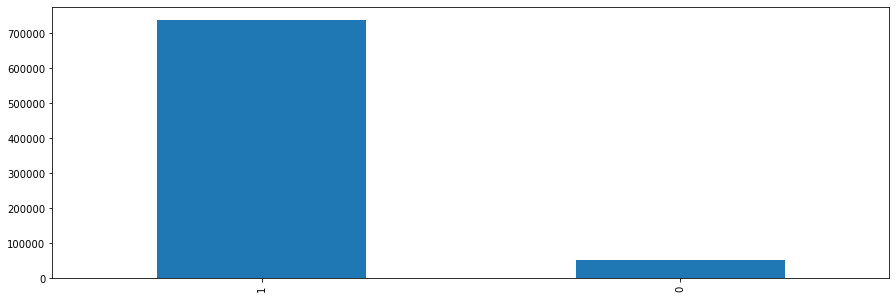

In [22]:
plt.figure(figsize=(15,5))
df_predict_input["Churn"].value_counts().plot.bar()

## Training & validation

We are now ready to run our model. We opt for a logistic regression to estimate the probability of customers leaving in the prediction window. The model will also allow us to identify relationships between the different features and the customer churn.

We will be using the ‘ScikitLearn’ package.

In [23]:
X, y = df_predict_input.drop(columns=["Churn"]), df_predict_input["Churn"]

In [24]:
# Normalize numeric features
numeric_features = ['Visits', 'Age', 'Visits (t-1)', 'Visits (t-2)', 
                    'Visits Rolling Avg', 'Visits Rolling Avg (t-1)', 'Visits Rolling Avg (t-2)']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Encode categorical features
categorical_features = ['SubscriptionType', 'Club', 'Affluence', 'Gender']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Pipeline, including undersampling
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('sampling', NearMiss(1)),
                      ('classifier', LogisticRegression(max_iter=10000))])

# Train, validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Training
clf.fit(X_train, y_train)

# Validation
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.552


In [25]:
df_proba = clf.predict_proba(X)

Let's have a look at the most important features:

In [26]:
features = numeric_features
features.extend(clf['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features).tolist())

In [45]:
importances = clf.named_steps['classifier'].coef_[0]

best_features = pd.DataFrame(columns=['Feature', 'Importance', 'abs'])

for f in range(len(features)):
    best_features = best_features.append({'Feature': features[f], 
                                          'Importance': importances[f], 
                                          'abs': abs(importances[f])}, ignore_index=True)

best_features = best_features.sort_values(by='abs', ascending=False)
best_features["Group"] = best_features["Feature"].str.split("_", 1).str[0]

best_features.groupby('Group').first()

,Feature,Importance,abs
Group,,,
Affluence,Affluence_DE,-3.160260,3.160260
Age,Age,-0.211355,0.211355
Club,Club_Redbridge,-2.271259,2.271259
Gender,Gender_Female,-0.068354,0.068354
SubscriptionType,SubscriptionType_Flexible,-1.224007,1.224007
Visits,Visits,-0.716725,0.716725
Visits (t-1),Visits (t-1),-0.155852,0.155852
Visits (t-2),Visits (t-2),-0.028350,0.028350
Visits Rolling Avg,Visits Rolling Avg,0.242728,0.242728


In [48]:
best_features.groupby('Group').first().to_excel("Features.xlsx")

Perhaps surprisingly, our model seems to give most weight to the categorical features. This could be an indication that we do not necessarily need to collect a lot of visit data to identify customers which are at risk to cancel their subscription.

However, rather than relying on a binary prediction we would recommend to take actions based on probabilities which can easily be extracted from the model. One idea could be to build a "churn risk" indicator per customer to identify customers for which it makes sense to take remediating actions to prevent them from leaving.

In [28]:
df_proba

array([[0.44599574, 0.55400426],
       [0.22486173, 0.77513827],
       [0.5274552 , 0.4725448 ],
       ...,
       [0.88264483, 0.11735517],
       [0.35937495, 0.64062505],
       [0.14389962, 0.85610038]])